In [ ]:
import pandas as pd
import numpy as np
import mpu
from time import time
from matplotlib import pyplot as plt
from matplotlib import animation

In [ ]:
df = pd.read_csv('city.csv')

In [ ]:
df.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000001,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000001,2200,UTC+7,53.347997,83.779806,635585,1730


In [ ]:
df = df.sort_values(by='population', ascending=False)[:30]
df.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
509,г Москва,101000.0,Россия,Центральный,г,Москва,NaN,NaN,NaN,NaN,...,1,0,45000000000,45000000,7700,UTC+3,55.754047,37.620405,11514330,1147
786,г Санкт-Петербург,190000.0,Россия,Северо-Западный,г,Санкт-Петербург,NaN,NaN,NaN,NaN,...,1,0,40000000000,40000000,7800,UTC+3,59.939131,30.315900,4848742,1703
647,г Новосибирск,630000.0,Россия,Сибирский,обл,Новосибирская,NaN,NaN,г,Новосибирск,...,4,2,50401000000,50701000001,5400,UTC+7,55.028191,82.921149,1498921,1893
832,г Екатеринбург,620000.0,Россия,Уральский,обл,Свердловская,NaN,NaN,г,Екатеринбург,...,4,2,65401000000,65701000001,6600,UTC+5,56.838522,60.605491,1377738,1723
619,г Нижний Новгород,603000.0,Россия,Приволжский,обл,Нижегородская,NaN,NaN,г,Нижний Новгород,...,4,2,22401000000,22701000001,5200,UTC+3,56.324063,44.005391,1250615,1221


In [ ]:
class City:
  def __init__(self, address, geo_lat, geo_lon):
    self.address = address
    self.geo_lat = geo_lat
    self.geo_lon = geo_lon
  
  def __repr__(self):
    return f"{self.address}: ({self.geo_lat, self.geo_lon})"

cities = []
for _, row in df.iterrows():
  cities.append(City(row['address'], row['geo_lat'], row['geo_lon']))
cities = np.array(cities)
cities[0]

г Москва: ((55.7540471, 37.620405))

## Simulated Annealing

The steps are as described in task description. First, get the initial state, set $T$, $alpha$. Then, repeat the following steps until $T \le 1$:
1. Randomly select 2 cities and swap them. This new state is $x'$.
2. Calculate $p^*(x') = e^{(-dist(x') / T)}$.
3. Calculate $p^*(x_t) = e^{(-dist(x_t) / T)}$.
4. Generate $u$ ~ $U(0, 1)$.
5. If $u \le \frac{p^*(x')}{p^*(x_t)}$, then $x_{t+1} = x'$. Otherwise, $x_{t + 1} = x_t$
6. $T = \alpha * T$.

In [ ]:
def calc_proposed_state(cur_state):
  indeces = np.random.choice(len(cur_state), 2, replace=False)
  min_index = min(indeces[0], indeces[1])
  max_index = max(indeces[0], indeces[1])
  proposed_state = np.copy(cur_state)
  proposed_state[[min_index, max_index]] = proposed_state[[max_index, min_index]]
  return proposed_state

def calc_distance(first_city, second_city):
  return mpu.haversine_distance(
      (first_city.geo_lat, first_city.geo_lon), 
      (second_city.geo_lat, second_city.geo_lon)
      )

def calc_path_length(state):
  length = calc_distance(state[-1], state[0])
  for i in range(1, len(state)):
    length += calc_distance(state[i-1], state[i])
  return length

def calc_next_state(cur_state, T):
  proposed_state = calc_proposed_state(cur_state)
  
  non_zero_T = T + 1e-9
  e_proposed_state = -calc_path_length(proposed_state)
  e_current_state = -calc_path_length(cur_state)
  alpha = np.exp((e_proposed_state - e_current_state) / non_zero_T)

  u = np.random.rand(1)[0]

  return proposed_state if u <= alpha else cur_state


def run_sa(initial_state, T, alpha, save_history = False):
  cur_state = initial_state
  history = [cur_state]
  while T > 1:
    path_length = calc_path_length(cur_state)
    cur_state = calc_next_state(cur_state, T)
    T = T * alpha
    history.append(cur_state)
  path_length = calc_path_length(cur_state)
  return history[-1] if(not save_history) else history

    

In [ ]:
run_sa(cities, 1000, 0.4)

array([г Москва: ((55.7540471, 37.620405)),
       г Санкт-Петербург: ((59.9391313, 30.3159004)),
       г Новосибирск: ((55.028191, 82.9211489)),
       г Екатеринбург: ((56.8385216, 60.6054911)),
       г Нижний Новгород: ((56.3240627, 44.0053913)),
       г Казань: ((55.7943584, 49.1114975)),
       г Самара: ((53.1950306, 50.1069518)),
       г Омск: ((54.9848566, 73.3674517)),
       г Челябинск: ((55.1602624, 61.4008078)),
       г Ростов-на-Дону: ((47.2224566, 39.718803)),
       г Саратов: ((51.533557, 46.034257)),
       г Волгоград: ((48.7070042, 44.5170339)),
       г Ижевск: ((56.852738, 53.2114896)),
       г Красноярск: ((56.0093879, 92.8524806)),
       г Воронеж: ((51.6593332, 39.1969229)),
       г Уфа: ((54.734944, 55.9578468)),
       г Краснодар: ((45.0401604, 38.9759647)),
       Самарская обл, г Тольятти: ((53.5205348, 49.3894028)),
       г Барнаул: ((53.3479968, 83.7798064)),
       г Пермь: ((58.0102583, 56.2342034)),
       г Ульяновск: ((54.3079415, 48.374848

## Convergence speed for different  annealing rates

Higher value of $\alpha$ leads to higher number of iterations. However, as one can see from the 2nd plot, more iterations doesn't necessarily lead to better results. It is not guaranteed to obtain the global optimum.

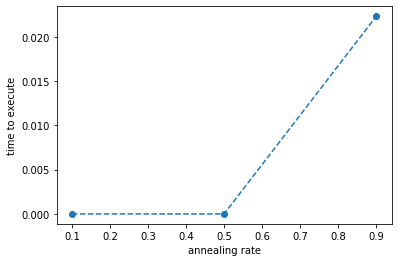

In [ ]:
annealing_rates = [0.1, 0.5, 0.9]
T = 500

times = []
final_lengths = []
for a in annealing_rates:
  start_time = time()
  state = run_sa(cities, T, a)
  end_time = time()
  times.append(end_time - start_time)
  final_lengths.append(calc_path_length(state))

plt.ylabel("time to execute")
plt.xlabel("annealing rate")
plt.scatter(annealing_rates, times)
plt.plot(annealing_rates, times, '--')
plt.show()

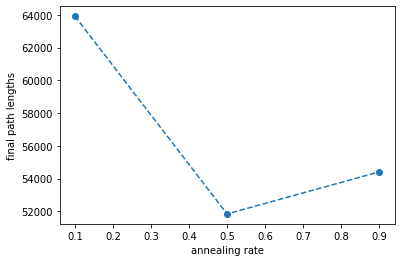

In [ ]:
plt.ylabel("final path lengths")
plt.xlabel("annealing rate")
plt.scatter(annealing_rates, final_lengths)
plt.plot(annealing_rates, final_lengths, '--')
plt.show()

## Animation

reference:
https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c

<ipython-input-6-7e2ede621eb6>:27: RuntimeWarning: overflow encountered in exp
  alpha = np.exp((e_proposed_state - e_current_state) / non_zero_T)
MovieWriter imagemagick unavailable; using Pillow instead.


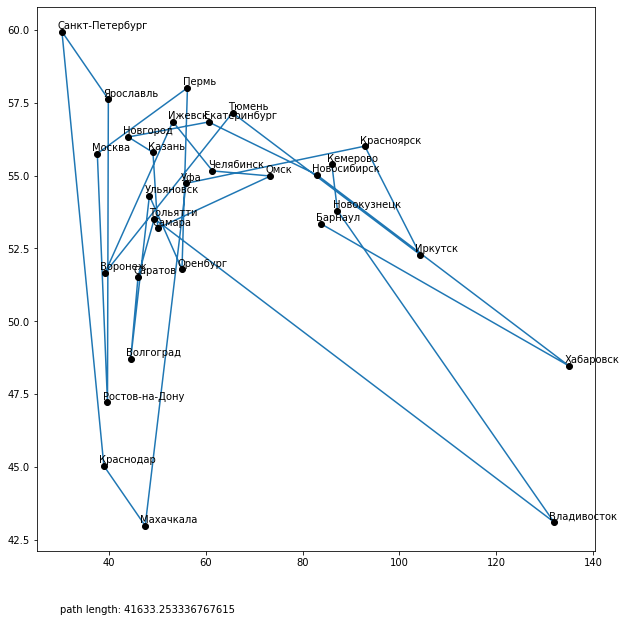

In [ ]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()

path, = ax.plot([], [])
text = ax.text(30, 40, '')

history = run_sa(cities, T, alpha = 0.9, save_history = True)

def init():
  path.set_data([], [])
  text.set_text('')
  return path, text

def animate(i):
  current_state = history[i]
  geo_lats = []
  geo_lons = []
  for city in current_state:
    geo_lats.append(city.geo_lon)
    geo_lons.append(city.geo_lat)
  path.set_data(geo_lats, geo_lons)
  text.set_text(f"path length: {calc_path_length(current_state)}")
  return path, text

for city in cities:
    ax.plot(city.geo_lon, city.geo_lat, marker='o', color='black')
    ax.text(city.geo_lon - 1, city.geo_lat + 0.1, city.address.split()[-1])
 

result = animation.FuncAnimation(fig, animate, init_func=init, frames=len(history) - 1, interval=20, repeat=False)
result.save('result.gif', writer='imagemagick')

plt.show()